In [19]:
def create_rgb_segmentation(segmentation, num_classes=None):
    """
    Convert a segmentation map to an RGB visualization using a precise colormap.

    Args:
        segmentation (torch.Tensor): Segmentation map of shape [B, H, W] where
                                      each pixel contains class labels (natural numbers).
        num_classes (int): The number of unique classes in the segmentation.

    Returns:
        torch.Tensor: RGB visualization of shape [B, 3, H, W].
    """
    if len(segmentation.shape) == 4:
        segmentation = segmentation.argmax(dim=1)
    if num_classes is None:
        num_classes = segmentation.max().item() + 1
    
    # Define a precise colormap for specific classes
    colormap = torch.tensor([
        [0, 0, 0],       # Class 0: Black (Background)
        [0, 0, 128],     # Class 4: Blue
        [128, 0, 0],     # Class 1: Red
        [128, 128, 0],   # Class 3: Yellow
        [0, 128, 0],     # Class 2: Green
        [128, 0, 128],   # Class 5: Magenta
        [0, 128, 128],   # Class 6: Cyan
        [192, 192, 192], # Class 7: Light Gray
    ], dtype=torch.uint8)  # Ensure dtype is uint8

    # Initialize an empty tensor for RGB output
    B, H, W = segmentation.shape
    rgb_segmentation = torch.zeros((B, 3, H, W), dtype=torch.uint8)

    # Loop through each class and assign the corresponding RGB color
    for class_id in range(num_classes):
        # Create a mask for the current class
        class_mask = (segmentation == class_id).unsqueeze(1)  # Shape: [B, 1, H, W]
        # Assign the corresponding color to the rgb_segmentation
        rgb_segmentation += class_mask * colormap[class_id].view(1, 3, 1, 1)  # Broadcasting

    return rgb_segmentation

In [3]:
from peft import LoraConfig, get_peft_model
from tqdm import tqdm
from label_anything.loss import LabelAnythingLoss
from label_anything.experiment.substitution import Substitutor
from label_anything.utils.metrics import DistributedMulticlassJaccardIndex, to_global_multiclass
from torch.optim import AdamW

import lovely_tensors as lt
import torch
lt.monkey_patch()

/leonardo/home/userexternal/pdemarin/miniconda3/envs/label-anything/lib/python3.11/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/leonardo/home/userexternal/pdemarin/miniconda3/envs/label-anything/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/leonardo/home/userexternal/pdemarin/miniconda3/envs/label-anything/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [4]:
from label_anything.data import get_dataloaders
from label_anything.models import model_registry
from label_anything.utils.utils import torch_dict_load

In [5]:
dataset_args = {
    'datasets': {
        'val_coco20i_N2K5': {
            'name': 'coco',
            'instances_path': 'data/coco/annotations/instances_val2014.json',
            'emb_dir': 'data/coco/vit_b_sam_embeddings/last_block_state',
            'img_dir': 'data/coco/train_val_2017',
            'split': 'val',
            'val_fold_idx': 3,
            'n_folds': 4,
            'n_shots': 5,
            'n_ways': 2,
            'do_subsample': False,
            'add_box_noise': False,
        },
    },
    'common': {
        'remove_small_annotations': True,
        'do_subsample': False,
        'add_box_noise': True,
        'max_points_annotations': 70,
        'max_points_per_annotation': 10,
        'load_gts': False,
        'image_size': 480,
        "load_embeddings": False,
        "custom_preprocess": False,
    }
}

dataloader_args = {
    'num_workers': 0,
    'possible_batch_example_nums': [[1, 2, 4]],
    'val_possible_batch_example_nums': [[1, 1]],
    'prompt_types': ["mask"],
    'prompt_choice_level': ["episode"],
    'val_prompt_types': ["mask"],
}

In [6]:
train, val_dict, test = get_dataloaders(dataset_args, dataloader_args, num_processes=1)
val = val_dict['val_coco20i_N2K5']

Loading dataset annotations from data/coco/annotations/instances_val2014.json...


In [7]:
dataset_categories = next(iter(val.dataset.datasets.values())).categories

In [8]:
dataset_categories

{4: {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 8: {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 13: {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 17: {'supercategory': 'animal', 'id': 17, 'name': 'cat'},
 21: {'supercategory': 'animal', 'id': 21, 'name': 'cow'},
 25: {'supercategory': 'animal', 'id': 25, 'name': 'giraffe'},
 32: {'supercategory': 'accessory', 'id': 32, 'name': 'tie'},
 36: {'supercategory': 'sports', 'id': 36, 'name': 'snowboard'},
 40: {'supercategory': 'sports', 'id': 40, 'name': 'baseball glove'},
 44: {'supercategory': 'kitchen', 'id': 44, 'name': 'bottle'},
 49: {'supercategory': 'kitchen', 'id': 49, 'name': 'knife'},
 53: {'supercategory': 'food', 'id': 53, 'name': 'apple'},
 57: {'supercategory': 'food', 'id': 57, 'name': 'carrot'},
 61: {'supercategory': 'food', 'id': 61, 'name': 'cake'},
 65: {'supercategory': 'furniture', 'id': 65, 'name': 'bed'},
 73: {'supercategory': 'electronic', 'id': 73, 'name': 'laptop'},
 

In [9]:
batch_tuple, data_name = next(iter(val))

In [10]:
for batch_tuple, data_name in val:
    cats = [dataset_categories[x]['name'] for img in batch_tuple[0]['classes'][0] for x in img]
    print(cats)
    if "cat" in cats:
        break

['snowboard', 'snowboard', 'snowboard', 'snowboard', 'snowboard', 'snowboard', 'baseball glove', 'baseball glove', 'baseball glove', 'baseball glove', 'baseball glove']
['cell phone', 'cell phone', 'cell phone', 'cell phone', 'cell phone', 'cell phone', 'truck', 'truck', 'truck', 'truck', 'truck']
['tie', 'tie', 'tie', 'tie', 'tie', 'tie', 'laptop', 'laptop', 'laptop', 'laptop', 'laptop']
['laptop', 'laptop', 'laptop', 'laptop', 'laptop', 'laptop', 'giraffe', 'giraffe', 'giraffe', 'giraffe', 'giraffe']
['sink', 'sink', 'sink', 'sink', 'sink', 'sink', 'truck', 'truck', 'truck', 'truck', 'truck']
['giraffe', 'giraffe', 'giraffe', 'giraffe', 'giraffe', 'giraffe', 'cat', 'cat', 'cat', 'cat', 'cat']


In [11]:
batch, gt = batch_tuple

images = batch["images"]
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
images = images * std + mean

In [20]:
masks = [create_rgb_segmentation(mask) for mask in batch["prompt_masks"].cpu()]

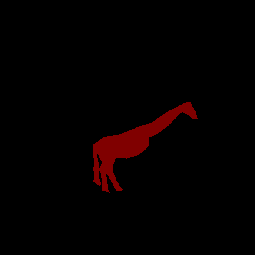

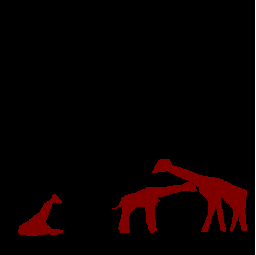

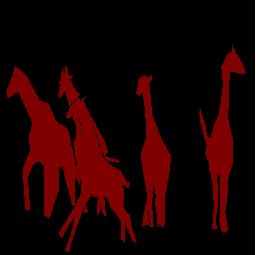

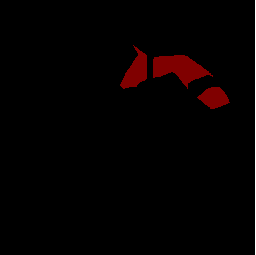

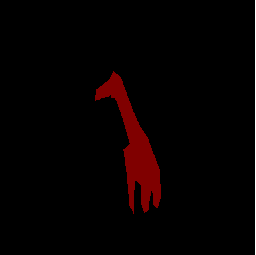

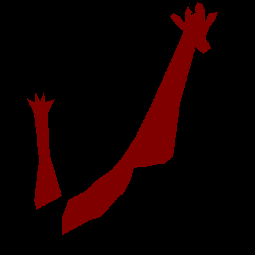

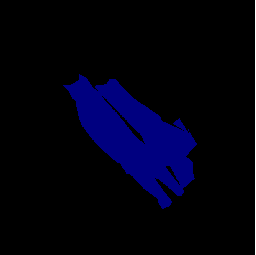

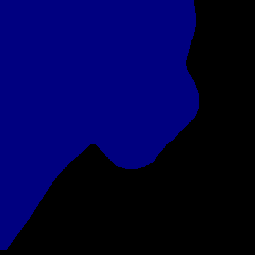

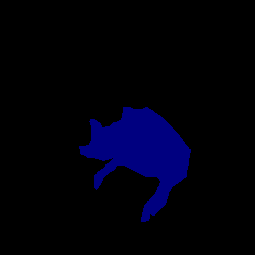

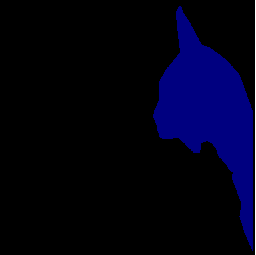

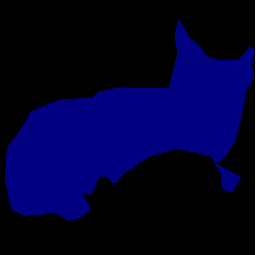

In [21]:
from IPython.display import display
for mask in masks:
    for mask in masks[0]:
        display(mask.rgb)

In [18]:
masks[0][-2].rgb.fig.savefig("mask.png")

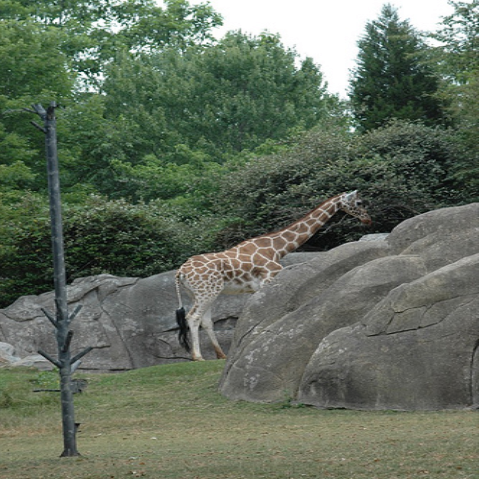

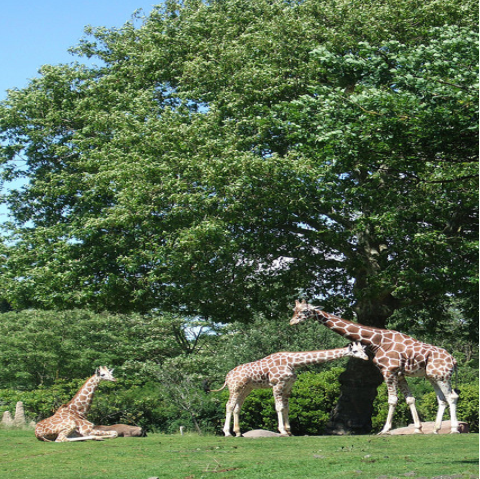

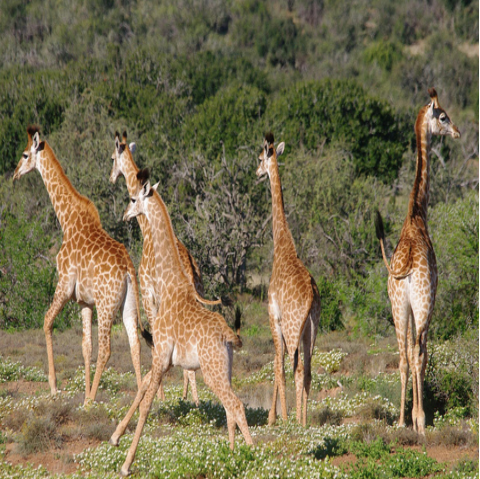

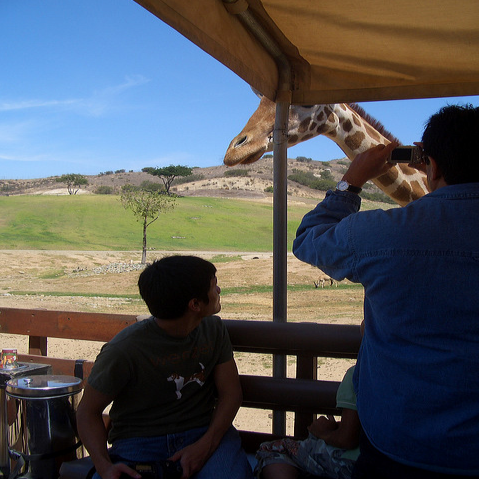

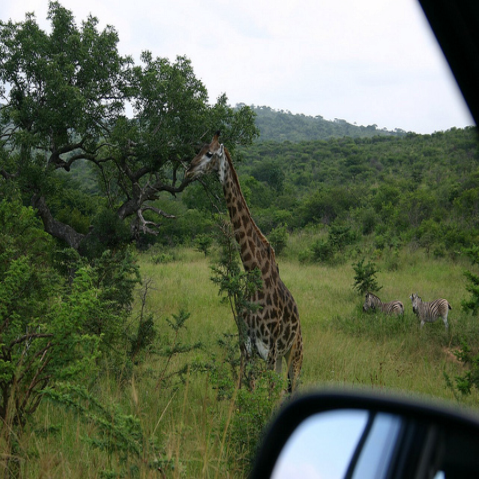

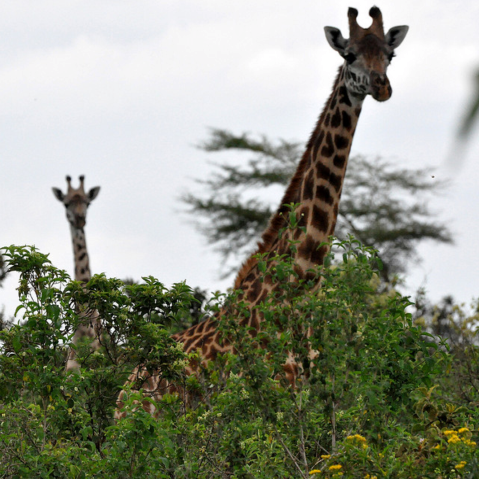

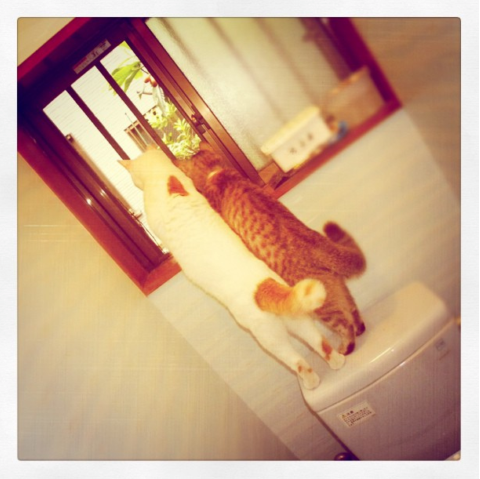

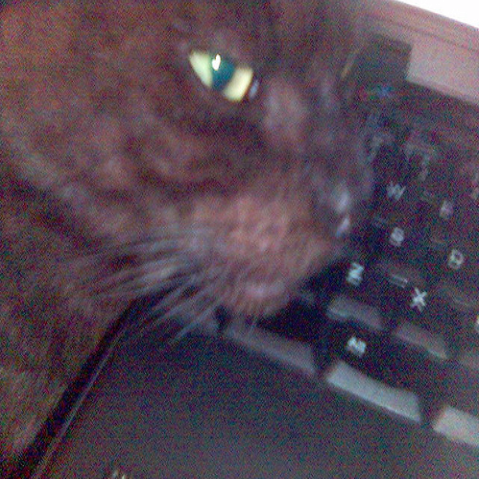

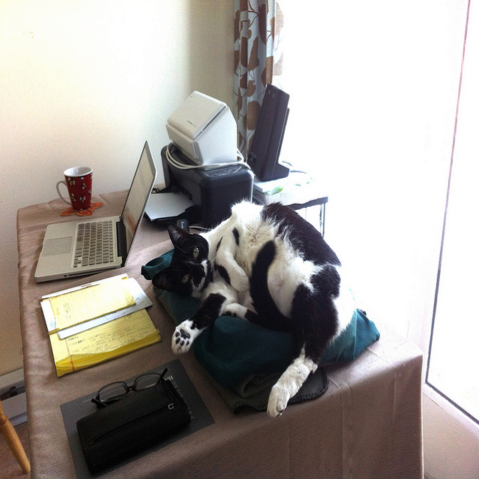

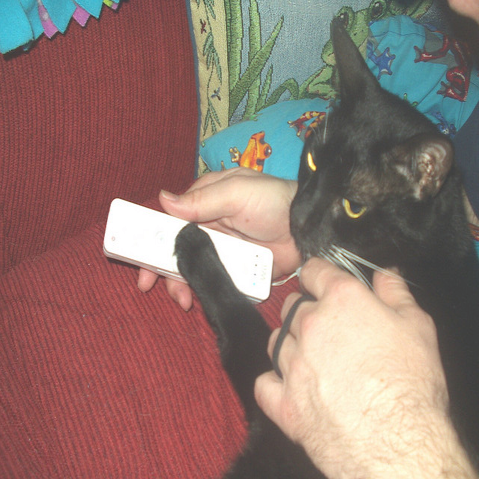

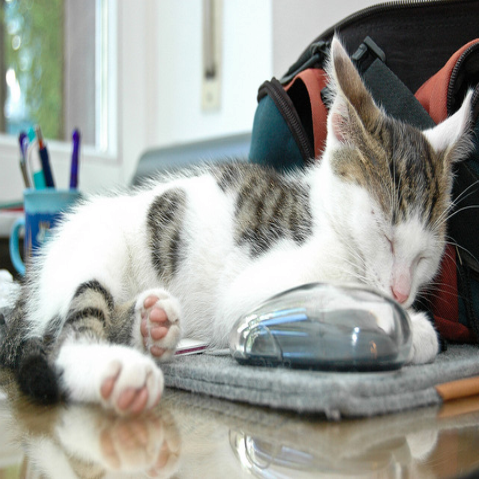

In [14]:
for image in images[0]:
    display(image.rgb)

In [1]:
import pandas as pd

In [3]:
df = pd.read_csv("results/lorafss_la.csv")

In [6]:
def filter_dataframe(df, filter_dict):
    # Start with all True mask
    mask = pd.Series(True, index=df.index)
    
    # Add each filter condition
    for column, value in filter_dict.items():
        mask = mask & (df[column] == value)
    
    # Apply the mask to get filtered data
    return df[mask]

In [7]:
hyperparameters_cols = ["lora_r", "lr"]
hyperparameters = df[hyperparameters_cols].drop_duplicates()
hyperparameters

lora_r      lr
0       64  0.0010
1       32  0.0010
2       16  0.0010
5       64  0.0001
8       32  0.0001
16      16  0.0001

In [50]:
def get_results(df, hyperparameter_dict):
    selected_cols = ["miou_orig"]
    filtered_df = filter_dataframe(df, hyperparameter_dict)
    num_iterations = filtered_df["num_iterations"].max()
    gain_columns = [f"gain_it_{i}" for i in range(1, num_iterations)]
    assert len(filtered_df) == 4, f"Expected 4 results, got {len(filtered_df)}"
    selected_df = filtered_df[selected_cols + gain_columns]
    mean_df = selected_df.mean()
    # Get the column where the mean is the highest
    best_column = mean_df[gain_columns].idxmax()
    best_gain = mean_df[best_column]
    
    final_df = filtered_df[[best_column, "val_fold_idx"]].set_index("val_fold_idx")[[best_column]].T
    final_df["mean"] = best_gain
    final_df["best_iteration"] = int(best_column.split("_")[-1])
    for key, value in hyperparameter_dict.items():
        final_df[key] = value
    final_df = final_df.reset_index(drop=True)
    # Remove val_fold_idx column
    return pd.DataFrame(final_df.to_dict())

dfs = []
for hyperparameter_dict in hyperparameters.to_dict(orient="records"):
    dfs.append(get_results(df, hyperparameter_dict))
results = pd.concat(dfs, ignore_index=True)
results

0         3         1         2      mean  best_iteration  lora_r  \
0  0.060139  0.034649  0.027544  0.020222  0.035638               4      64   
1  0.053865  0.037082  0.042566  0.046239  0.044938               4      32   
2  0.051186  0.024350  0.045612  0.042858  0.041001               4      16   
3  0.045341  0.023197  0.024116  0.026165  0.029705               4      64   
4  0.037677  0.020713  0.017503  0.020090  0.023996               4      32   
5  0.023326  0.016880  0.012359  0.012942  0.016377               4      16   

       lr  
0  0.0010  
1  0.0010  
2  0.0010  
3  0.0001  
4  0.0001  
5  0.0001